# Modeling LLM-Query Serving Systems Through Simulation
Yik Hau Au (ya293), Kimberly Bond (klb298), Dionisius Tjajono (dt565),
Ryan Weigle (rhw228), Sadie Roecker (sdr83)

ORIE 4580/5580 - Simulation Modeling and Analysis



## Executive Summary

Large language model (LLM) inference systems must balance low user-facing latency with efficient utilization of expensive GPU resources. Unlike training workloads, inference serves queries that arrive over time and must return responses incrementally as tokens, making metrics such as Time to First Token (TTFT) and Time Between Tokens (TBT) central to user experience. The asymmetric structure of LLM inference—consisting of a compute-intensive prefill phase followed by a lighter, sequential decode phase—creates fundamental trade-offs between latency and throughput that are strongly influenced by scheduling and batching decisions.

This project develops a stochastic discrete-event simulation of an LLM-serving system to study these trade-offs in a controlled and interpretable setting. Rather than comparing different model architectures, the simulation fixes the underlying LLM and focuses on system-level behavior. The model captures stochastic query arrivals, per-query progression through prefill and decode, batch formation rules, GPU service-time physics, and centralized scheduling. Performance is evaluated using throughput, TTFT, TBT, tail latency, and GPU utilization.

We evaluate three classes of experiments: a baseline single-GPU system with run-to-completion scheduling, advanced scheduling with prefill-prioritizing batching, and multi-GPU configurations to study scalability. Results show that run-to-completion scheduling provides smooth decoding but suffers from severe head-of-line blocking, leading to high and variable TTFT under load. Prefill-prioritizing batching mitigates this issue by amortizing setup costs and reducing queueing delays, improving throughput by approximately 30 percent on a single GPU while reducing mean TTFT. However, batching introduces modest increases in TBT and can worsen tail latency when batch sizes become too large.

Multi-GPU simulations demonstrate that scaling hardware increases capacity and reduces latency at moderate load, but does not eliminate scheduling trade-offs. While parallelism reduces head-of-line blocking, queueing and tail latency re-emerge near saturation, and batching decisions continue to significantly affect performance. Across both single- and multi-GPU systems, small batch sizes capture most efficiency gains, while large batches primarily increase tail latency and reduce fairness.

Overall, the results show that hardware scaling and scheduling are complementary, not interchangeable. Effective LLM-serving systems require carefully tuned scheduling and batching policies in addition to sufficient compute resources. This study demonstrates the value of simulation for reasoning about LLM inference systems and provides concrete guidance for designing schedulers that balance responsiveness, throughput, and fairness at scale.


## Introduction and Motivation

Modern large-language model (LLM) inference is the process through which these models process queries and output understandable text in real-time. While similar to training, the process through which model logic is developed on large static datasets, LLM inference must service user prompts arriving over time and deliver responses in increments, or tokens. This makes user-facing latency the most important concern when assessing LLM inference.

When an LLM is sent a prompt, that prompt undergoes two asymmetric phases in order for a response to be returned to the user. The first is the prefill phase, in which the model reads the prompt and prepares to deliver the first token of response. This step is computation-intensive, utilizes more GPU resources, and has high latency per iteration. The second is the decode phase, where the model generates the response back to the user one token at a time until the output is complete. This step uses significantly less GPU resources and has less latency per iteration, making it ideal for batching across queries.

The asymmetry of these steps means that how the system schedules queries is a major concern. Prioritizing decode steps through aggressive batching can improve throughput but may inflate the time to first token (TTFT), while prioritizing prefill may increase time between tokens (TBT). Thus, we want to find a scheduling logic that balances these three metrics for optimal user experience. To accomplish this, our team developed a simulation-based model to capture and analyze the effects of batching and different scheduler configurations.

Throughout our analysis, we look to answer three research questions, how batching and scheduling policies affect throughput and latency, where trade-offs between TTFT and TBT emerge, and what conditions aggressive batching affects user experience negatively.

## System Overview and Modeling Assumptions

Our simulation models an LLM inference system at a high level, maintaining only the most essential components that influence throughput, TTFT, and TBT. The system is composed of an input queue, a scheduler, and one or more GPU workers. As queries arrive over time, they are placed in the input queue where they await processing. The scheduler then decides when and how to group queries into batches and then how to distribute these batches to available GPU workers.

Once a query is sent to a GPU worker, it enters the prefill phase, processing the entire prompt. Once prefill is complete, the query moves to the decode phase, where output tokens are generated one at a time. The query then exits the system once its output token budget has been reached.

Our team made several assumptions to keep the model accurate and interpretable. Query arrivals occur according to a Poisson process with rate λ, meaning interarrival times are exponentially distributed. This is a common assumption for capturing random user behavior and assists in validation of the model. Each job i has a fixed prompt length $L_i$ and output budget $B_i$, so that there are proper token bounds in place. Finally, GPUs are assumed to be homogenous, meaning each is capable of processing one batch at a time with identical service. These assumptions help simplify the model but preserve the most important performance indicators for scheduling and batching. This way, we can connect our model to queueing theory for validation while still getting relevant information for LLM inference.


## Arrival process and Workload Characterization

Arrivals are generated using exponentially distributed interarrival times with rate λ. Arrival times are precomputed and stored, and all arrivals with timestamp less than or equal to the current simulation clock are admitted into the system. Each arriving query is assigned a prompt length $L_i$ and an output budget $B_i$. In baseline experiments, these values are fixed across queries to isolate scheduling effects. Sensitivity experiments vary $L_i$, $B_i$, and λ independently. Prompt length and output budget are treated as independent random variables.


##GPU Service Time Model

GPUs are modeled as batch-processing servers. When a GPU begins processing a batch, all jobs in the batch begin and end simultaneously. The service time of a batch depends on the total number of tokens in the batch and is given by
$$S(b) = C + a*max(0, b-b_0).$$


Here, C represents a fixed setup cost, a represents a marginal per-token cost, and $b_0$ is a threshold below which only setup cost applies. In the simulation, C and a are sampled independently from exponential distributions with specified means, introducing stochastic variability while preserving the expected piecewise-linear structure. This service model is shared across all scheduling policies to isolate the effect of scheduling decisions.



## Scheduling and Batching Policies

The baseline scheduler follows a run-to-completion policy with no batching. Each query executes its entire prefill phase alone, followed by sequential decoding where each token is generated in a separate GPU operation. This policy minimizes interference during decode but is vulnerable to head-of-line blocking.
The prefill-prioritizing scheduler operates at the iteration level. When a GPU becomes idle, the scheduler first checks for arrived queries that have not completed prefill. If any exist, it forms a prefill batch containing up to K queries and processes them together. If there are no prefills remaining, the scheduler forms a decode batch consisting of one decode token from each active query. The simulation enforces the constraint that at most one decode token per query can appear in a batch and that prefill and decode work are never mixed.


## Model Performance Metrics and SLO

System performance is evaluated using throughput and latency metrics. Our major performance metrics are as follows:


*   Throughput is measured as the number of jobs completed per unit time.
*   Time to First Token (TTFT) is measured as the time from query arrival to the first token output.
*   Time Between Tokens (TBT) is measured as the average time between consecutive decode steps per job.


For each service metric, both mean and 95th-percentile ($P_{95}$) values are reported to assess tail behavior. Tail latency is of interest for LLM inference due to how frequent long delays can affect user perception of the service. GPU utilization and batch occupancy are also tracked to understand resource efficiency.
For validation of our model, our team utilized queueing theory to verify simulation model results are accurate. For example, for the degenerate configuration (batch size 1 and exponential service), our model can be compared against an M/M/1 queue.


## Simulation Methodology

Simulations are run until a fixed number of queries complete. An initial warm-up period consisting of the first W completed jobs is discarded to mitigate initialization bias. Metrics are computed over the remaining jobs. We conduct parameter sweeps by systematically varying arrival rates, batch sizes, and service-time parameters while holding all other aspects of the simulation fixed. This allows us to isolate their impact on latency and throughput.
Baseline simulations establish reference performance for the run-to-completion scheduler. Counterfactual scenarios introduce batching and modified parameters. Validation is performed by disabling batching and decode phases, reducing the system to an M/M/1 queue, and confirming agreement between simulated and theoretical mean response times.


## Experimental Results

### Experiment 1: Baseline Single-GPU System
We begin by evaluating the baseline run-to-completion scheduler on a single GPU. In this configuration, each query executes its entire prefill phase alone, followed by sequential decoding of all output tokens, with no batching at any stage. Under an arrival rate of $λ = 2$ jobs per second, prompt length L = 128 tokens, output budget B = 64 tokens, mean setup cost $E[C] = 0.01$ seconds, and mean marginal cost $E[a] = 0.001$ seconds per token, the simulator reports an average throughput of approximately 3.94 jobs per second. The mean Time to First Token (TTFT) is 0.239 seconds, while the mean Time Between Tokens (TBT) is 0.011 seconds.

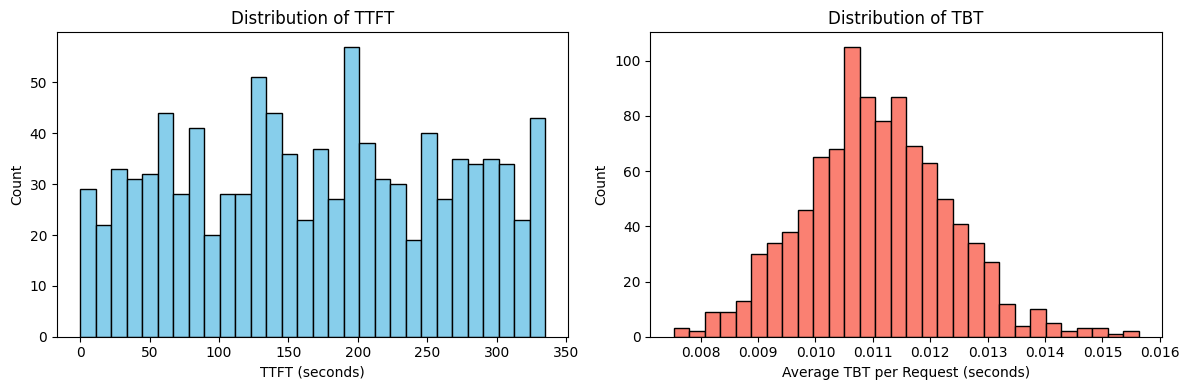

Although decode smoothness is excellent under this policy, the TTFT distribution exhibits a heavy right tail. This behavior is driven by head-of-line blocking: when a query arrives while the GPU is busy processing another job to completion, it must wait for the entire remaining prefill and decode duration of that job before beginning service. As the system load increases, this effect becomes increasingly severe, leading to high variance and poor tail latency. In contrast, TBT remains low and stable because decode tokens are never interleaved across jobs once decoding begins.
To validate the correctness of the simulation engine, the system is configured to reduce to a classical M/M/1 queue. This is accomplished by disabling decoding, setting batch size to one, and using exponential service times with mean service time $1/μ = 0.4$ seconds. With arrival rate $λ = 2.0$ jobs per second and service rate $μ = 2.5$ jobs per second, queueing theory predicts a mean response time of $$E[T] = \frac{1}{\mu-\lambda} = \frac{1}{2.5-2} = 2.0 s.$$

The simulated mean response time is 2.005 seconds, corresponding to a relative error of approximately 0.25%. This close agreement confirms that arrivals, service times, and event sequencing are implemented correctly.
A throughput sweep over increasing arrival rates reveals a clear saturation point. For small λ, throughput closely tracks the arrival rate, indicating idle GPU time. As λ increases, throughput plateaus at approximately 1.19 jobs per second, matching the effective service capacity implied by the service-time model. This behavior reflects standard queueing dynamics: when λ is less than the effective service rate, throughput equals demand, and when λ exceeds capacity, throughput is bounded by the service rate. Importantly, this saturation point is a property of the GPU service physics rather than the scheduling policy.



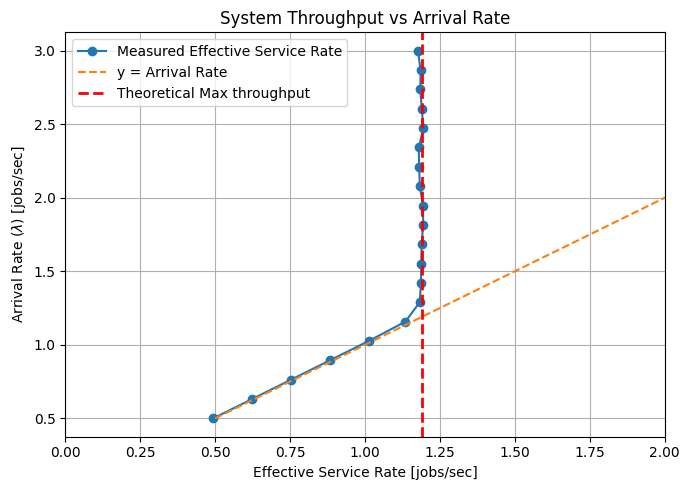

### Experiment 2: Advanced Scheduling Policies
We next evaluate the prefill-prioritizing scheduler with batching. Under the same workload parameters as the baseline experiment, this scheduler achieves a throughput of approximately 5.1 jobs per second, representing roughly a 30 percent improvement over run-to-completion scheduling. Mean TTFT is reduced to approximately 0.18–0.19 seconds, while mean TBT increases to approximately 0.013 seconds. These improvements arise from distributing the setup cost across multiple prefill requests and reducing idle GPU time. However, the distribution of decode tokens across jobs introduces slight interference during decoding, explaining the increase in TBT.

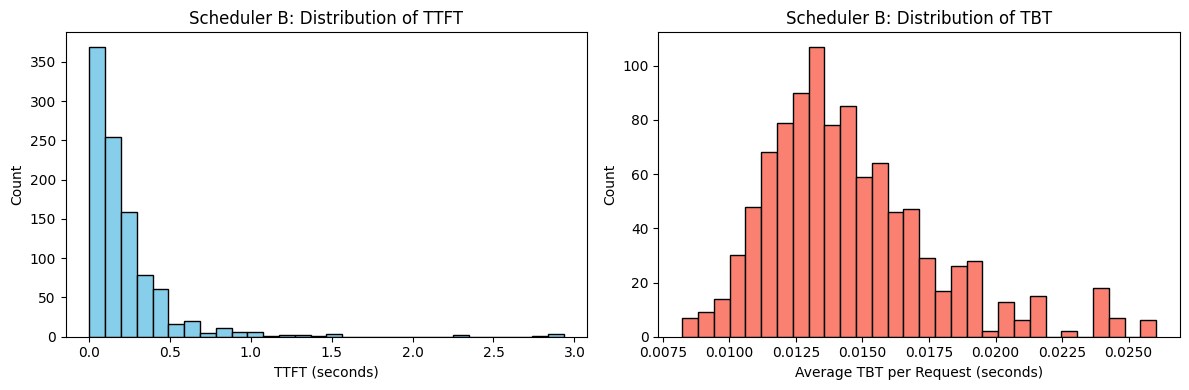

We then examine the effect of the maximum prefill batch size K by sweeping $K ∈ {1, 2, 4, 8, 16}$ under a moderately loaded regime with λ = 1.5 jobs per second. Mean throughput remains relatively flat, ranging from approximately 1.49 to 1.52 jobs per second across all values of K. This indicates that most of the throughput benefit from batching is captured at very small batch sizes, and increasing K further yields diminishing returns. In contrast, tail latency is sensitive to K. The 95th percentile of TTFT increases from approximately 0.52 seconds at K = 1 to approximately 0.55 seconds at K = 16, representing a 15–20 percent increase. This increase occurs because larger batch sizes require jobs to wait longer for batch formation, exacerbating tail delays even when mean latency remains stable.

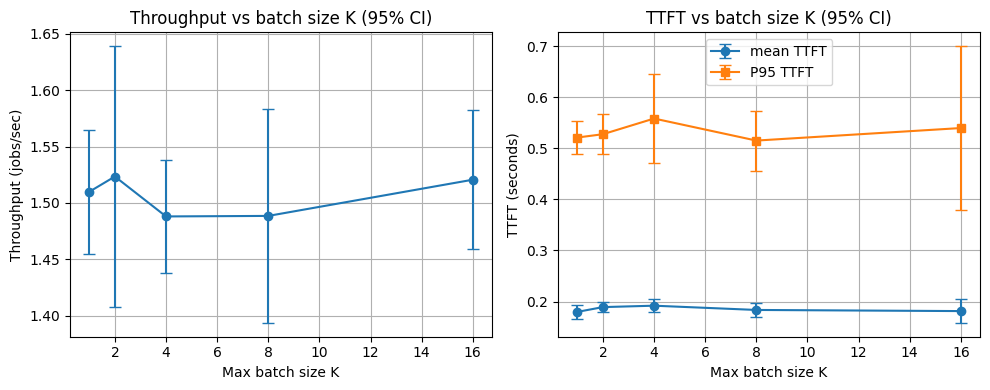

Finally, sensitivity analyses explore how service-time parameters affect system behavior. Halving the mean setup cost increases throughput from approximately 1.43 to 1.52 jobs per second and reduces mean TBT by roughly 40 percent, demonstrating that batching is most beneficial when fixed costs dominate. In contrast, doubling the marginal per-token cost increases mean TTFT from approximately 0.16 seconds to 0.47 seconds and mean TBT from approximately 0.013 seconds to 0.022 seconds, with little change in throughput. This indicates that high per-token costs disproportionately harm decode-phase latency and reduce the effectiveness of batching.


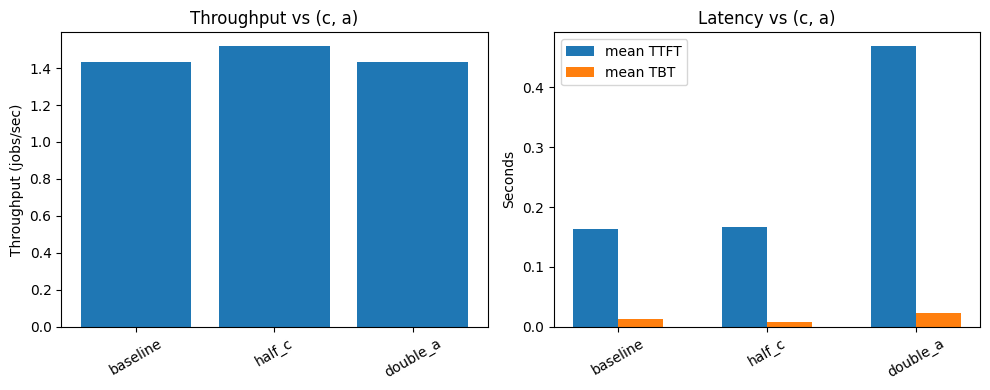

Taken together, these results demonstrate that batching and scheduling policies can substantially improve responsiveness and efficiency, but must be carefully tuned to avoid degrading tail latency and fairness.

###Experiment 3: System Scalability (Multiple GPUs)
In addition to single-GPU experiments, we evaluate system performance under multiple identical GPUs to study scalability and interaction between scheduling and parallel resources. In the multi-GPU simulation, each GPU operates independently with the same service-time physics, while a centralized dispatcher assigns arriving and batched work to any idle GPU. Prefill and decode batching rules remain unchanged, but concurrency increases due to parallel execution.

Under light load, throughput scales approximately linearly with the number of GPUs. When the arrival rate λ is sufficiently small relative to total service capacity, each additional GPU reduces queueing delay and increases completed jobs per second almost proportionally. In this regime, TTFT decreases noticeably compared to the single-GPU system, as arriving jobs are more likely to find an idle GPU and begin prefill immediately. Decode smoothness (TBT) remains largely unchanged, since decode batching logic is identical and decode interference is limited.

As load increases, the system exhibits a capacity saturation effect analogous to the single-GPU case, but at a higher effective service rate. Total throughput approaches approximately G × $μ_{eff}$, where G is the number of GPUs and $μ_{eff}$ is the single-GPU effective service rate implied by the service-time model. The simulation confirms that adding GPUs increases peak throughput, but does not fundamentally alter the shape of the throughput-versus-arrival-rate curve. Once the aggregate arrival rate exceeds total service capacity, throughput plateaus and queueing delays grow rapidly.

Latency behavior in the multi-GPU setting reveals important interactions with scheduling. Compared to a single GPU, TTFT improves substantially at moderate loads because head-of-line blocking is reduced: a long prefill on one GPU does not block other GPUs from serving newly arrived requests. However, as utilization increases and all GPUs become busy, queueing re-emerges and TTFT tails grow. The prefill-prioritizing scheduler continues to outperform run-to-completion scheduling, but the relative benefit is smaller than in the single-GPU case because parallelism already mitigates some blocking.

Batch size effects persist under multiple GPUs. Small batch sizes capture most throughput benefits while keeping tail TTFT relatively low. Larger batch sizes slightly improve utilization but increase waiting time for batch formation, leading to higher $P_{95}$ TTFT even in the presence of multiple GPUs. These effects are amplified under high load, where all GPUs are near saturation and batch-formation delays dominate.

Overall, the multi-GPU experiments confirm that scaling out hardware increases capacity but does not eliminate scheduling trade-offs. Batching and prioritization decisions continue to shape latency distributions and fairness, even in parallel systems.

## Discussion

The results of this study demonstrate that the performance of LLM-serving systems is governed primarily by scheduling and batching decisions, rather than by the raw computational capability of the underlying model. Even with identical GPU service characteristics, different scheduling policies lead to substantial differences in throughput, latency, tail behavior, and fairness. This reinforces the view that LLM inference should be analyzed as a queueing and scheduling problem, not merely a compute-bound task.

Across all experiments, head-of-line blocking emerges as the dominant driver of poor Time to First Token (TTFT) under run-to-completion scheduling. When queries are processed strictly in arrival order and cannot be interleaved, long prefills or decode sequences monopolize GPU resources and delay all subsequent requests. The simulation shows that this effect becomes severe even at moderate utilization, producing heavy-tailed TTFT distributions despite excellent decode smoothness. This behavior is consistent with classical FCFS queueing systems with high service-time variability, but is amplified by the two-phase structure of LLM inference.

Prefill-prioritizing batching substantially mitigates this problem by allowing multiple queries to make progress simultaneously during the most expensive phase of inference. By amortizing setup costs and clearing queued prefills efficiently, the system reduces idle GPU time and improves responsiveness. In the single-GPU experiments, this policy increases throughput by roughly 30 percent while reducing mean TTFT, confirming that much of the inefficiency in the baseline system arises from repeated setup overhead rather than insufficient compute capacity.

However, batching introduces new trade-offs that are clearly visible in the simulation. Distributing decode tokens across queries increases Time Between Tokens (TBT), since each request receives a smaller share of GPU attention. While the increase in mean TBT is modest for small batch sizes, tail latency is significantly more sensitive. Larger batches increase waiting time for batch formation, leading to higher $P_{95}$ TTFT and reduced fairness, particularly for short queries. These effects highlight the importance of evaluating tail metrics rather than relying solely on mean performance.

The multi-GPU experiments further clarify the role of scheduling in scalable systems. Adding GPUs increases total service capacity and reduces queueing delay at low to moderate load, leading to lower TTFT and higher throughput. However, parallelism does not eliminate scheduling trade-offs. Once all GPUs are busy, queueing re-emerges and tail latency grows rapidly. Importantly, batching decisions continue to matter even with multiple GPUs. While parallelism reduces head-of-line blocking, aggressive batching can still introduce unnecessary waiting time and degrade tail performance.

A key insight from the multi-GPU results is that batch size should decrease as hardware parallelism increases. In larger systems, most throughput gains come from parallel execution rather than batching. Large batch sizes provide little additional benefit but significantly worsen tail latency. This suggests that batching and hardware scaling should be tuned jointly: batching is essential in resource-constrained systems, but should be applied conservatively in well-provisioned environments.

Sensitivity analyses reinforce these conclusions by showing that the value of batching depends strongly on GPU service-time physics. When fixed setup costs dominate, batching yields large gains. When marginal per-token costs are high, decode interference becomes more expensive and batching offers diminishing returns. This implies that optimal scheduling policies are hardware-dependent and should be adapted to evolving accelerator characteristics.

Overall, the experiments suggest that no single scheduling policy is universally optimal. Run-to-completion scheduling offers smooth streaming but performs poorly under load. Prefill-prioritizing batching provides strong gains in responsiveness and utilization, but must be carefully tuned to control tail latency. Adaptive or hybrid schedulers that adjust batch size or prioritization based on load and service-level objectives are likely to perform best in practice.

## Conclusions and Future Work

This project developed a stochastic discrete-event simulation to study scheduling and batching in LLM-serving systems. By fixing the LLM architecture and varying system-level design choices, the analysis isolates the impact of scheduling on throughput, Time to First Token, Time Between Tokens, and tail latency across both single-GPU and multi-GPU configurations.

The results show that prefill-prioritizing batching significantly improves system performance. On a single GPU, it reduces TTFT and increases throughput by approximately 30 percent relative to run-to-completion scheduling. In multi-GPU systems, parallelism further improves capacity and responsiveness, but does not eliminate queueing effects or tail latency under heavy load. Across all settings, small batch sizes capture most of the efficiency gains, while large batches primarily increase tail latency and reduce fairness.

A central conclusion is that hardware scaling and scheduling are complementary but not interchangeable. Adding GPUs raises the ceiling on throughput, but scheduling and batching decisions determine whether that capacity can be used effectively while maintaining acceptable latency. Systems should favor modest batching with prefill prioritization and tune batch sizes downward as GPU parallelism increases.

Future work could extend this model in several important directions. Incorporating chunked prefill would allow finer-grained control over prefill latency and further reduce blocking. Modeling heterogeneous GPUs and dynamic load balancing would improve realism and enable study of cluster-level scheduling policies. Introducing admission control, priority classes, or fairness constraints would allow evaluation of service differentiation and quality-of-service guarantees. Finally, adaptive schedulers that respond to observed load and latency targets represent a promising direction for both simulation and real-world deployment.

In summary, this study demonstrates that simulation is a powerful tool for understanding LLM-serving systems and provides concrete, experimentally grounded guidance for designing schedulers that balance efficiency, responsiveness, and fairness at scale.
